In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
%matplotlib inline
import pymesh
#https://pymesh.readthedocs.io/en/latest/basic.html
import time
import multiprocessing
import meshplot
import itertools
from multiprocessing import Pool #  Process pool
from multiprocessing import sharedctypes
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
from mshmthds import *
from BYORP_YORP import *
import sys




The surface thermal inertia is neglected, so that thermal radiation is re-emitted with no time lag, and the reflected and thermally radiated components are assumed Lambertian (isotropic) and so emitted with flux
parallel to the local surface normal. We ignore heat conduction. The surface is described with a closed
triangular mesh.


The radiation force from the $i$-th facet is
$$ {\bf F}_i  = - \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) \hat {\bf n}_i $$
where  $S_i$ is the area of the $i$-th facet and $\hat {\bf n}_i$ is its surface normal.
Here $F_\odot$ is the solar radiation flux and $c$ is the speed of light.
The direction of the Sun is $\hat {\bf s}_\odot$.

The total Yarkovsky force is a sum over all the facets 
$${\bf F}_Y = \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\bf F}_i $$
Only facets on the day side  or with $\hat {\bf n}_i \cdot \hat {\bf s}_\odot >0$ 
are included in the sum.

The torque affecting the binary orbit from a single facet is 
$$ {\boldsymbol \tau}_{i,B} = 
\begin{cases} 
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) ( {\bf a}_B \times \hat {\bf n}_i)  
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
 0 & \mbox{otherwise}
 \end{cases}
$$
where ${\bf a}_B$ is the secondary's radial vector from the binary center of mass.


The torque affecting the binary orbit is the sum of the torques from each facet and should be an average 
over the orbit around the Sun and 
over the binary orbit and spin of the secondary.
$$ {\boldsymbol \tau}_{BY} = \frac{1}{T} \int_0^T dt\   \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} 
{\boldsymbol \tau}_{i,B} $$


If $\hat {\bf l}$ is the binary orbit normal then 
$$ {\boldsymbol \tau}_{BY} \cdot \hat {\bf l} $$ 
changes the binary's orbital angular momentum and causes binary orbit migration.


The torque affecting the spin (also known as YORP) instantaneously depends on 
the radii of each facit ${\bf r}_i$ from the asteroid center of mass 
$$ {\boldsymbol \tau}_{i,s}  = \begin{cases}
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot)  ({\bf r}_i \times \hat{\bf n}_i) 
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
0 & \mbox{otherwise}
\end{cases}$$


$$ {\boldsymbol \tau}_Y = \frac{1}{T} \int_0^T dt \  \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\boldsymbol \tau}_{i,s} $$
where the average is done over the orbit about the Sun and the spin of the asteroid.
If the spin axis is $\hat {\boldsymbol \omega}$ then 
$$ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \omega}  $$ gives the body spin up or spin down rate.


In practice we average over the Sun's directions first and then average over spin (for YORP) or and spin and binary orbit direction (for BYORP) afterward.


<b> Units </b> 

For our calculation are $F_\odot/c = 1$.

For YORP $R=1$.
For BYORP $a_B = 1$ and $R=1$ (in the surface area).

Here $R$ is volume equivalent sphere radius.

To put in physical units: 

Multiply ${\boldsymbol \tau}_Y$ by $\frac{F_\odot R^3}{c}$.

Multiply ${\boldsymbol \tau}_{BY}$ by $\frac{F_\odot R^2 a_B}{c}$.

Alternatively we are computing:

${\boldsymbol \tau}_Y \times \frac{c}{F_\odot R^3} $ 

${\boldsymbol \tau}_{BY} \times \frac{c}{F_\odot R^2 a_B} $ 


To get the rate the spin changes for YORP

$\dot \omega = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\bf s} }{C} $

where $C$ is the moment of inertia about the spin axis.

To order of magnitude what we are computing can be multiplied by 
$\frac{F_\odot R^3}{c MR^2} $ to estimate $\dot \omega$
and by $\frac{F_\odot R^3}{c MR^2 \omega} $
to estimate $\dot \epsilon$. 

To get the rate that obliquity changes for YORP

$\dot \epsilon = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \phi} }{C \omega} $

where unit vector $\hat {\boldsymbol \phi}$ is in the xy plane (ecliptic) and is perpendicular to the spin axis.

To get the semi-major axis drift rate for BYORP

$ \dot a_B = \frac{2 {\boldsymbol \tau}_{BY} \cdot \hat {\bf l}}{M n_Ba_B} $

where $M$ is the secondary mass, $n_B$ and $a_B$ are binary orbit mean motion and semi-major axis.

To order of magnitude to get the drift rate we multiply what we are getting by 
$\frac{F_\odot R^2 a_B}{c} \times \frac{1}{M n_B a_B}$.


Dimensionless numbers used by Steiberg+10 (eqns 19,48)

$f_{Y} \equiv \tau_{Y} \frac{3}{2} \frac{c}{\pi R^3 F_\odot}$

$f_{BY} \equiv \tau_{BY} \frac{3}{2} \frac{c}{\pi R^2 a_B F_\odot}$

Our computed values are  the same as theirs except for a factor of 3/2 
(but they have a 2/3 in their torque) and a factor of $\pi$.
We need to divide by $\pi$ to have values consistent with theirs.

<b> Assumptions:</b>

Circular orbit for binary.

Circuilar orbit for binary around Sun.

No shadows.

No conduction. Lambertian isotropic emission. No thermal lag.

We neglect distance of facet centroids from secondary center of mass when computing BYORP. 

Coordinate system:
binary orbit is kept in xy plane

Compare YORP on primary to BYORP on secondary.

$\frac{\tau_{Yp}}{\tau_{BY} }\sim \frac{R_p^2 }{R_s^2 } \frac{R_p }{a_B }\frac{f_Y}{ f_{BY}}$

For Didymos, this is about $8 f_Y/f_{BY}$.

In [2]:
squannit = pymesh.load_mesh("kw4b.obj")
SIZEOFMESH = 0.03
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
folder = 'Squannit'+ str(len(short_squannit.faces))
print(folder)

Squannit790


Starting 1
Starting 3
Starting 2
Starting 0
Starting 5
Starting 4
Starting 7
Starting 6
Starting Analysis
Finished 6
Starting 8
Finished 3
Starting 9
Finished 1
Finished 4
Starting 10
Starting 11
Finished 5
Starting 12
Finished 7
Starting 13
Finished 2
Starting 14
Finished 0
Starting 15
Finished 8
Starting 16
Finished 9
Starting 17
Finished 11
Starting 18
Finished 12
Starting 19
Finished 13
Finished 10
Finished 15
Finished 14
Finished 16
Finished 17
Finished 18
Finished 19
Time to complete 121.28 second(s)


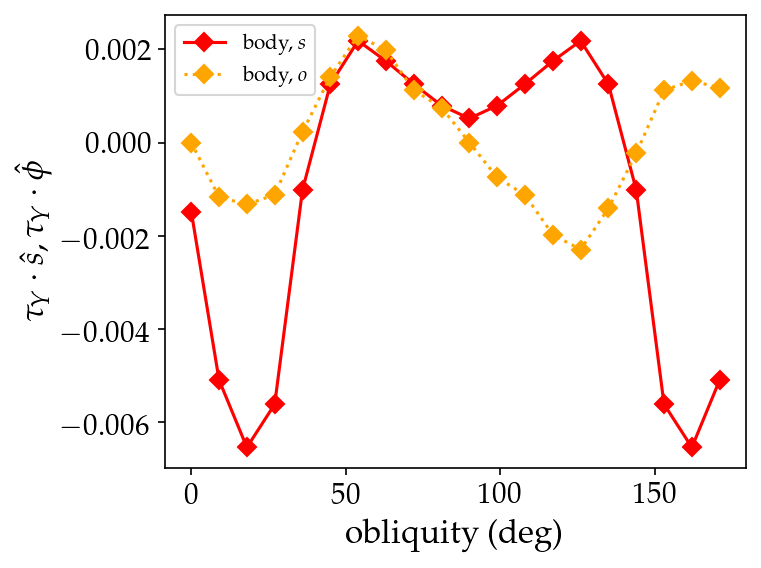

In [3]:
# compute the BYORP torque on body as a function of obliquity
# for a given inclination and precession angle
# returns obliquity and torque arrays
#Create the mesh
squannit = pymesh.load_mesh("kw4b.obj")
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
vertices = short_squannit.vertices
faces = short_squannit.faces

#Simulation Parameters
size = 20           # Number of Obliquities
block_size = 1      # Obliquities per subprocess
incl = 0; phi_prec=0


tau_s_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_tau_s = sharedctypes.RawArray(tau_s_arr._type_, tau_s_arr)
tau_o_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_tau_o = sharedctypes.RawArray(tau_o_arr._type_, tau_o_arr)


o_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_o = sharedctypes.RawArray(o_arr._type_, o_arr)

# YORP Methods

# compute the YORP torque on body as a function of obliquity 
# here obliquity is w.r.t Sun
# returns obliquity and torque arrays
def aj_alt_obliq_Y_fig(nobliq):
    body = pymesh.form_mesh(vertices, faces)
    body.add_attribute("face_area")
    body.add_attribute("face_normal")
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
#     nobliq = 20   # number of obliquities
    dobliq = np.pi/20  
    tau_s_arr = np.ctypeslib.as_array(shared_array_tau_s)  # to store torques
    tau_o_arr = np.ctypeslib.as_array(shared_array_tau_o)  # to store torques
    o_arr = np.ctypeslib.as_array(shared_array_o) # to store obliquities in degrees
    print(f'Starting {nobliq}')
    for i in range(nobliq, nobliq+block_size):
        obliquity=i*dobliq
        tau_Y_x,tau_Y_y,tau_Y_z,tau_s,tau_o =compute_Y(body,obliquity,nphi,nphi_Sun)
        #print(tau_s)
        tau_s_arr[i] = tau_s
        tau_o_arr[i] = tau_o
        o_arr[i] = obliquity*180/np.pi
    print(f'Finished {nobliq}')
    return o_arr, tau_s_arr, tau_o_arr

start=time.perf_counter()
p=Pool()

# compute YORPs as a function of obliquity (single body, obliquity w.r.t Solar orbit)
print('Starting Analysis')
res = p.map(aj_alt_obliq_Y_fig, range(size))
multi_o_arr = np.ctypeslib.as_array(shared_array_o)
multi_tau_arr_s = np.ctypeslib.as_array(shared_array_tau_s)
multi_tau_arr_o = np.ctypeslib.as_array(shared_array_tau_o)
end = time.perf_counter()
print(f'Time to complete {round(end - start,2)} second(s)')


# o_arr, tau_s_arr, tau_o_arr = obliq_Y_fig(body)
# also check the sphere for YORP
# o_arr2, tau_s_arr2,tau_o_arr2  = obliq_Y_fig(sphere)  # note y axis

# compare the two YORPs
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
# ax.plot(o_arr2,tau_s_arr2,'go-',label='sphere')
#ax.plot(o_arr2,tau_o_arr2,'bo-',label='sphere')
ax.plot(multi_o_arr,multi_tau_arr_s,'rD-',label=r'body, $s$')
ax.plot(multi_o_arr,multi_tau_arr_o,'D:',label='body, $o$', color='orange')
ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_Y \cdot \hat{ s}, { \tau}_Y \cdot \hat{\phi}$',fontsize=16)
ax.legend()
fig.savefig(folder+'/ObliqY')

Started 3
Started 5
Started 6
Started 2
Started 7
Started 4
Started 0
Started 1
Starting analysis
Finished 2
Started 8
Finished 5
Started 9
Finished 6
Started 10
Finished 3
Started 11
Finished 4
Started 12
Finished 0
Started 13
Finished 1
Finished 7
Started 14
Started 15
Finished 8
Started 16
Finished 9
Started 17
Finished 13
Started 18
Finished 10
Started 19
Finished 12
Finished 15
Finished 11
Finished 14
Finished 16
Finished 17
Finished 18
Finished 19
D8: time to complete 119.53 second(s)


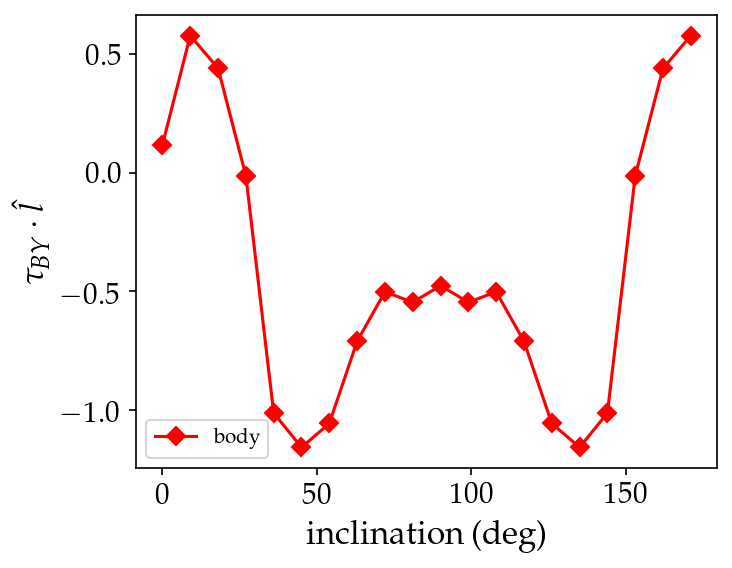

In [4]:
# compute the BYORP torque on body as a function of inclination
# for a given obliquity and precession angle
# returns inclination and torque arrays
#Create the mesh
squannit = pymesh.load_mesh("kw4b.obj")
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
vertices = short_squannit.vertices
faces = short_squannit.faces

#Simulation Parameters
size = 20           # Number of Inclinations
block_size = 1      # Obliquities per subprocess
obliquity = 0; phi_prec=0



tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)
i_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_i = sharedctypes.RawArray(i_arr._type_, i_arr)

def aj_alt_obliq_BY_fig(nincl):
    body = pymesh.form_mesh(vertices, faces)
    body.add_attribute("face_area")
    body.add_attribute("face_normal")
    #mesh.add_attribute("vertex_normal")
    body.add_attribute("face_centroid")
    f_area = body.get_attribute("face_area")
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    dincl = np.pi/size
    tau_l_arr = np.ctypeslib.as_array(shared_array_tau)  # to store torques
    i_arr = np.ctypeslib.as_array(shared_array_i)
    print(f'Started {nincl}')
    for i in range(nincl, nincl+block_size):
        incl=i*dincl
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        i_arr[i] = incl*180/np.pi
        tau_l_arr[i] = tau_l
    print(f'Finished {nincl}')
    return i_arr,tau_l_arr

# compute BYORPs as a function of inclination
# i_arr,tau_l_arr = obliq_BY_fig(body,obliquity,phi_prec)

start = time.perf_counter()
p = Pool()
#Complete BYORP analysis
print('Starting analysis')
res = p.map(aj_alt_obliq_BY_fig, range(20))
multi_i_arr = np.ctypeslib.as_array(shared_array_o)
multi_tau_l_arr = np.ctypeslib.as_array(shared_array_tau)
end = time.perf_counter()#Print Time
print(f'D8: time to complete {round(end - start,2)} second(s)')

fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.plot(multi_i_arr,multi_tau_l_arr,'rD-',label='body')
ax.set_xlabel('inclination (deg)',fontsize=16)
ax.set_ylabel(r'${\tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
fig.savefig(folder+'/InclBY')

Starting analysis
Finished 14
Finished 8
Finished 12
Finished 4
Finished 10
Finished 2
Finished 0
Finished 6
Finished 15
Finished 5
Finished 3
Finished 9
Finished 13
Finished 1
Finished 11
Finished 7
Finished 16
Finished 22
Finished 20
Finished 24
Finished 28
Finished 18
Finished 26
Finished 30
Finished 17
Finished 23
Finished 25
Finished 21
Finished 29
Finished 19
Finished 27
Finished 31
Finished 32
Finished 36
Finished 34
Finished 40
Finished 38
Finished 42
Finished 44
Finished 46
Finished 33
Finished 37
Finished 39
Finished 43
Finished 35
Finished 41
Finished 45
Finished 47
Finished 48
Finished 52
Finished 50
Finished 56
Finished 54
Finished 58
Finished 49
Finished 53
Finished 51
Finished 57
Finished 55
Finished 59
D8: time to complete 356.25 second(s)


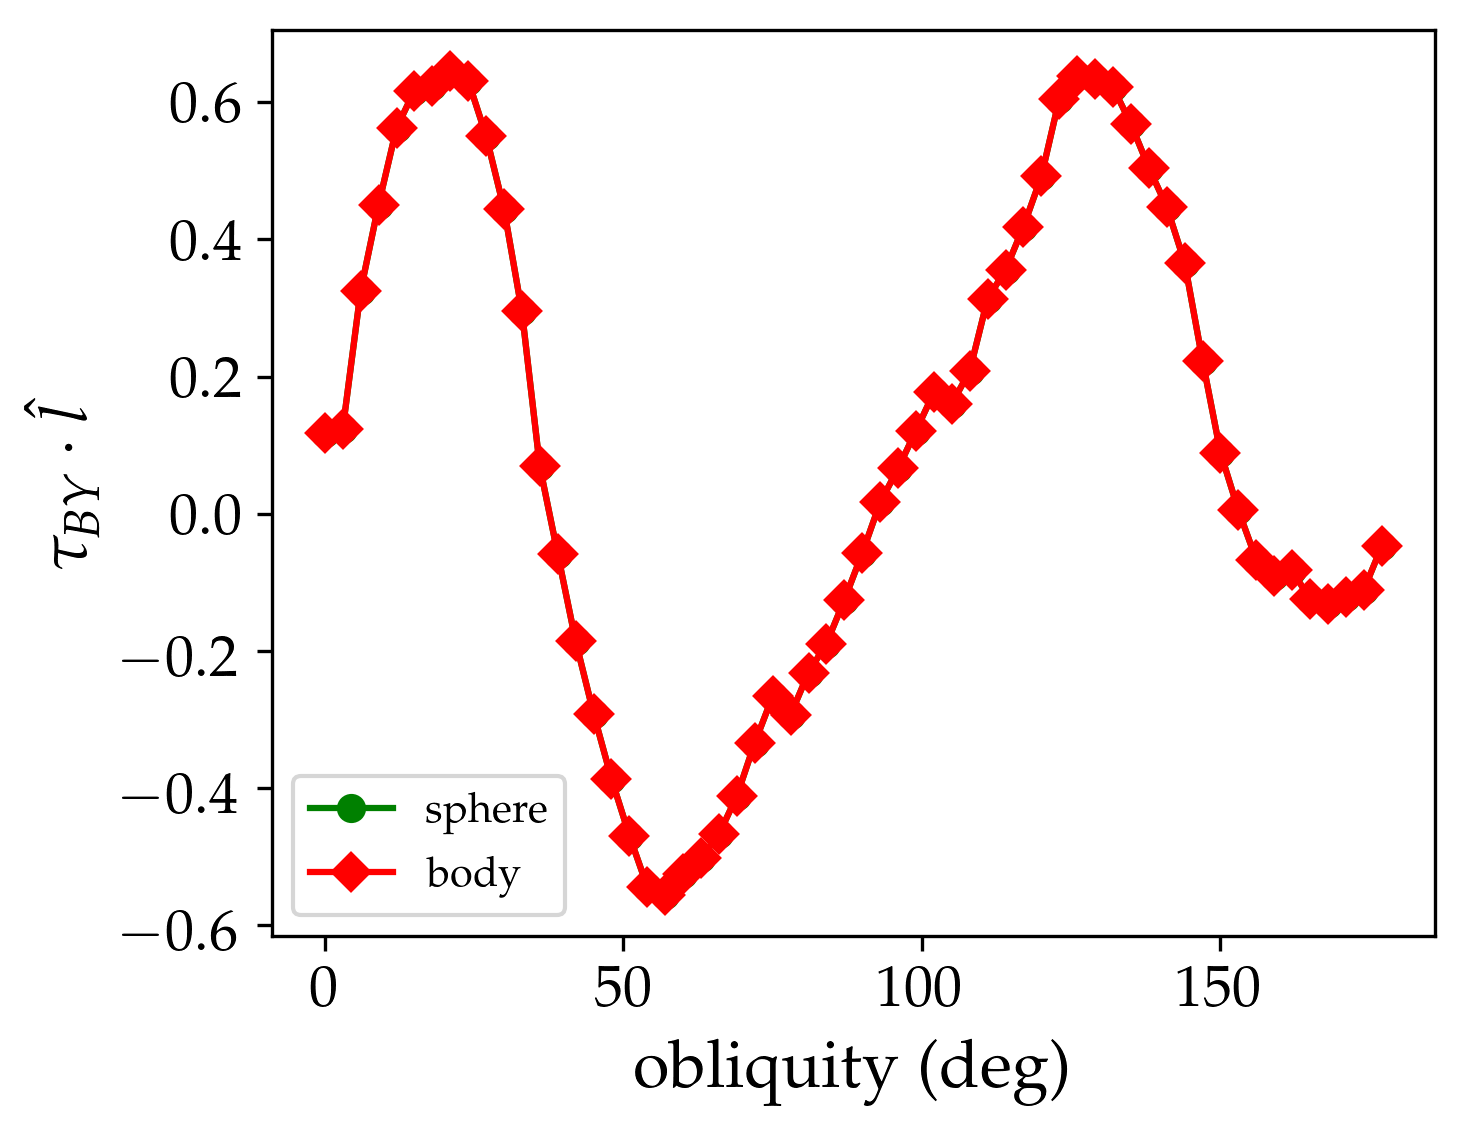

In [5]:
# compute the BYORP torque on body as a function of obliquity
# for a given inclination and precession angle
# returns obliquity and torque arrays
#Create the mesh
squannit = pymesh.load_mesh("kw4b.obj")
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
vertices = short_squannit.vertices
faces = short_squannit.faces

#Simulation Parameters
size = 60           # Number of Obliquities
block_size = 1      # Obliquities per subprocess
incl = 0; phi_prec=0



tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((60)))
shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)
o_arr = np.ctypeslib.as_ctypes(np.zeros((60)))
shared_array_o = sharedctypes.RawArray(o_arr._type_, o_arr)

def aj_alt_obliq_BY_fig2(nobliq):
    body = pymesh.form_mesh(vertices, faces)
    body.add_attribute("face_area")
    body.add_attribute("face_normal")
    #mesh.add_attribute("vertex_normal")
    body.add_attribute("face_centroid")
    f_area = body.get_attribute("face_area")
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    dobliq = np.pi/60
    tau_l_arr = np.ctypeslib.as_array(shared_array_tau)  # to store torques
    o_arr = np.ctypeslib.as_array(shared_array_o)
    for i in range(nobliq, nobliq+block_size):
        obliquity=i*dobliq
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l = compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        o_arr[i] = obliquity*180/np.pi
        tau_l_arr[i] = tau_l
    print(f'Finished {nobliq}')
    return o_arr,tau_l_arr


start = time.perf_counter()
p = Pool()
#Complete BYORP analysis
print('Starting analysis')
res = p.map(aj_alt_obliq_BY_fig2, range(60))
multi_o_arr = np.ctypeslib.as_array(shared_array_o)
multi_tau_l_arr = np.ctypeslib.as_array(shared_array_tau)
end = time.perf_counter()#Print Time
print(f'D8: time to complete {round(end - start,2)} second(s)')



fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=300)
ax.plot(multi_o_arr,multi_tau_l_arr,'go-',label='sphere')
ax.plot(multi_o_arr,multi_tau_l_arr,'rD-',label='body')
ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
fig.savefig(folder+'/ObliqBY')

Starting 7
Starting 3
Starting 0
Starting 4
Starting 5
Starting 2
Starting 1
Starting 6
Starting analysis
Finished 5
Starting 8
Finished 2
Starting 9
Finished 1
Starting 10
Finished 6
Finished 0
Starting 11
Starting 12
Finished 3
Starting 13
Finished 7
Starting 14
Finished 4
Starting 15
Finished 8
Starting 16
Finished 9
Starting 17
Finished 10
Starting 18
Finished 12
Starting 19
Finished 11
Starting 20
Finished 13
Starting 21
Finished 14
Starting 22
Finished 15
Starting 23
Finished 16
Starting 24
Finished 17
Starting 25
Finished 18
Starting 26
Finished 20
Starting 27
Finished 19
Starting 28
Finished 21
Starting 29
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 29
Finished 28
D8: time to complete 169.75 second(s)


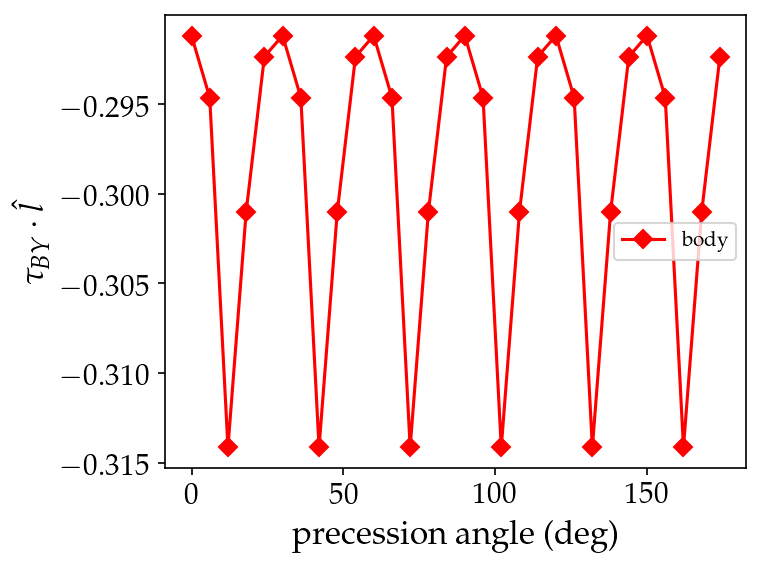

In [6]:
# compute the BYORP torque on body as a function of precession angle 
# for a given obliquity and inclination 
# returns precession angle and torque arrays

#Create the mesh
squannit = pymesh.load_mesh("kw4b.obj")
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
vertices = short_squannit.vertices
faces = short_squannit.faces


#Simulation Parameters
size = 30           # Number of Precession Angles
block_size = 1      # Precession < per subprocess
incl = 0; obliquity=np.pi/4

tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)
p_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_p = sharedctypes.RawArray(p_arr._type_, p_arr)




def aj_alt_obliq_BY_fig3(nprec):
    body = pymesh.form_mesh(vertices, faces)
    body.add_attribute("face_area")
    body.add_attribute("face_normal")
    #mesh.add_attribute("vertex_normal")
    body.add_attribute("face_centroid")
    f_area = body.get_attribute("face_area")
    
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    dprec = np.pi/size  # only goes from 0 to pi
    tau_l_arr = np.ctypeslib.as_array(shared_array_tau)  # to store torques
    p_arr = np.ctypeslib.as_array(shared_array_p)
    print(f'Starting {nprec}')
    for i in range(nprec, nprec+block_size):
        phi_prec=i*dprec
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        p_arr[i] = phi_prec*180/np.pi
        tau_l_arr[i] = tau_l
    print(f'Finished {nprec}')
    return p_arr,tau_l_arr



# compute BYORPs as a function of precession angle, seems not sensitive to precession angle
# p_arr,tau_l_arr = obliq_BY_fig3(body,obliquity,incl)

start = time.perf_counter()
p = Pool()
#Complete BYORP analysis
print('Starting analysis')
res = p.map(aj_alt_obliq_BY_fig3, range(size))
multi_p_arr = np.ctypeslib.as_array(shared_array_p)
multi_tau_l_arr = np.ctypeslib.as_array(shared_array_tau)
end = time.perf_counter()#Print Time
print(f'D8: time to complete {round(end - start,2)} second(s)')


fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.plot(multi_p_arr,multi_tau_l_arr,'rD-',label='body')
ax.set_xlabel('precession angle (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
fig.savefig(folder+'/PrecessBY')

Staring 0
Staring 4
Staring 5
Staring 2
Staring 3
Staring 1
Staring 6
Staring 7
Starting analysis
Finished 5
Staring 8
Finished 2
Staring 9
Finished 0
Staring 10
Finished 6
Staring 11
Finished 7
Staring 12
Finished 1
Staring 13
Finished 4
Staring 14
Finished 3
Staring 15
Finished 8
Staring 16
Finished 9
Staring 17
Finished 10
Staring 18
Finished 11
Finished 12
Staring 19
Finished 15
Finished 14
Finished 13
Finished 16
Finished 17
Finished 18
Finished 19
D8: time to complete 115.91 second(s)


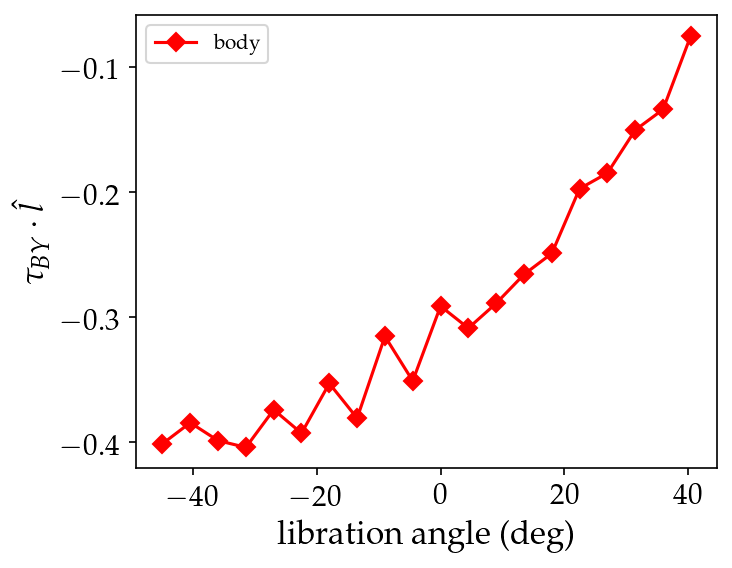

In [7]:
# compute the BYORP torque on body as a function of libration angle phi0 
# for a given obliquity and inclination  and precession angle
# returns libration angle and torque arrays

#Create the mesh
squannit = pymesh.load_mesh("kw4b.obj")
short_squannit, info = pymesh.collapse_short_edges(squannit, SIZEOFMESH)
vertices = short_squannit.vertices
faces = short_squannit.faces


#Simulation Parameters
size = 20           # Number of Libration Angles
block_size = 1      # Precession < per subprocess
incl = 0; phi_prec=0; obliquity = np.pi/4

tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)
l_arr = np.ctypeslib.as_ctypes(np.zeros((size)))
shared_array_l = sharedctypes.RawArray(l_arr._type_, l_arr)


def aj_alt_obliq_BY_fig4(nlib):
    body = pymesh.form_mesh(vertices, faces)
    body.add_attribute("face_area")
    body.add_attribute("face_normal")
    #mesh.add_attribute("vertex_normal")
    body.add_attribute("face_centroid")
    f_area = body.get_attribute("face_area")
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    dlib = 0.5*np.pi/size  # going from -pi/4 to pi/4
    tau_l_arr = np.ctypeslib.as_array(shared_array_tau)  # to store torques
    l_arr = np.ctypeslib.as_array(shared_array_l)
    print(f'Staring {nlib}')
    for i in range(nlib, nlib + block_size):
        phi0=i*dlib - np.pi/4
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        l_arr[i] = phi0*180/np.pi
        tau_l_arr[i] = tau_l
    print(f'Finished {nlib}')
    return l_arr,tau_l_arr



# compute BYORPs as a function of libration angle

# l_arr,tau_l_arr=obliq_BY_fig4(body,obliquity,incl,phi_prec)

#plt.savefig('tau_BY_lib.png')
# fairly sensitive to libration angle


start = time.perf_counter()
p = Pool()
#Complete BYORP analysis
print('Starting analysis')
res = p.map(aj_alt_obliq_BY_fig4, range(size))
multi_l_arr = np.ctypeslib.as_array(shared_array_l)
multi_tau_l_arr = np.ctypeslib.as_array(shared_array_tau)
end = time.perf_counter()#Print Time
print(f'D8: time to complete {round(end - start,2)} second(s)')


fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
#ax.plot(o_arr2,tau_l_arr2,'go-',label='sphere')
ax.plot(multi_l_arr,multi_tau_l_arr,'rD-',label='body')
ax.set_xlabel('libration angle (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
fig.savefig(folder+'/LibBY')